In [1]:
%reset -f
import sys
sys.path.insert(0,'..')
from wavhandler import *
# from utils_train import train_test_val_split
from pandas.plotting import register_matplotlib_converters
from utils_train import test_inds, test_days
register_matplotlib_converters()

In [2]:
data = Dataset('Wingbeats')
print(data.target_classes)

def train_test_filenames(dataset, species, train_dates=[], test_dates=[]):
    dataset.read(species, loadmat=False)
    dataset.get_sensor_features()
    sub = dataset.df_features
    sub.groupby('datestr')['filenames'].count().plot(kind="bar")
    print(sub['datestr'].unique().tolist())

    test_fnames = sub[sub.datestr.isin(test_dates)].filenames
    if len(train_dates): # if train dates are given
        train_fnames = sub[sub.datestr.isin(train_dates)].filenames
    else:
        train_fnames = sub[~sub.datestr.isin(test_dates)].filenames

    print("{} train filenames, {} test filenames".format(train_fnames.shape[0], test_fnames.shape[0]))
    return train_fnames, test_fnames

['Ae. aegypti', 'Ae. albopictus', 'An. arabiensis', 'An. gambiae', 'C. pipiens', 'C. quinquefasciatus']


### Ae. Aegypti

Data: Ae. aegypti.
Read 85553 filenames in 2.36 seconds.
['20170209', '20170208', '20170210', '20170206', '20170213', '20170211', '20170207', '20161213', '20170212', '20161212']
82989 train filenames, 2564 test filenames


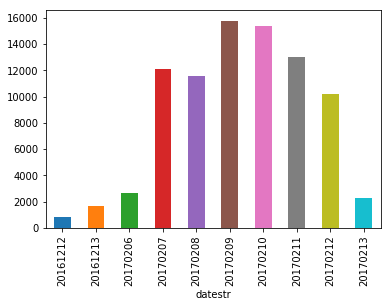

In [3]:
x1_tr, x1_ts = train_test_filenames(data,'Ae. aegypti', test_dates=['20161213','20161212'])

### Ae. albopictus

Data: Ae. albopictus.
Read 20231 filenames in 2.34 seconds.
['20170301', '20170228', '20170227', '20170103', '20170102']
17440 train filenames, 2791 test filenames


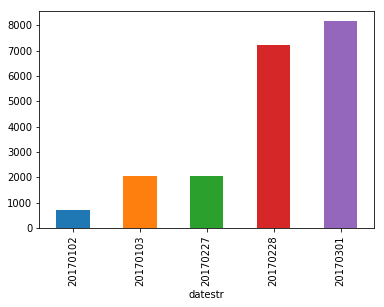

In [4]:
x2_tr, x2_ts = train_test_filenames(data,'Ae. albopictus', test_dates=['20170103', '20170102'])

### An. arabiensis

Data: An. arabiensis.
Read 19297 filenames in 2.36 seconds.
['20170313', '20170202', '20170315', '20170314', '20170318', '20170204', '20170201', '20170131', '20170203', '20170317', '20170320', '20170319', '20170316', '20170205', '20170206', '20170130']
12897 train filenames, 2831 test filenames


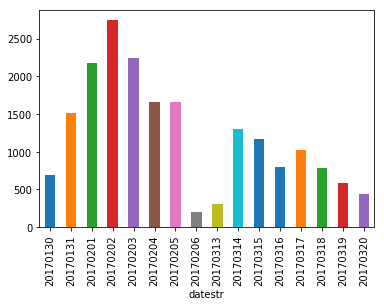

In [5]:
x3_tr, x3_ts = train_test_filenames(data,'An. arabiensis', test_dates=['20170319','20170320',
                                                                       '20170318','20170317'], train_dates=['20170201','20170202', '20170203','20170204',
                                                                                                            '20170205','20170206','20170131','20170130'])

### An. gambiae

Data: An. gambiae.
Read 49471 filenames in 2.42 seconds.
['20170110', '20170109', '20170116', '20170119', '20170120', '20170117', '20170121', '20170118', '20170122', '20170123']
45471 train filenames, 4000 test filenames


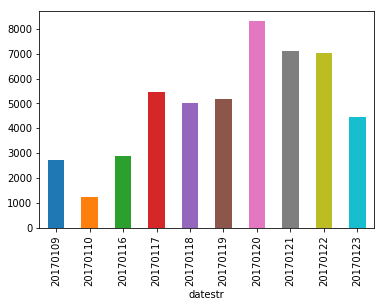

In [6]:
x4_tr, x4_ts = train_test_filenames(data,'An. gambiae', test_dates=['20170110', '20170109']) 

### Culex quinquefasciatus

Data: C. quinquefasciatus.
Read 74599 filenames in 2.36 seconds.
['20161220', '20161219', '20161221']
41552 train filenames, 33047 test filenames


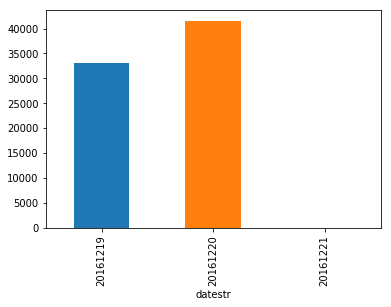

In [7]:
x5_tr, x5_ts = train_test_filenames(data,'C. quinquefasciatus', test_dates=['20161219']) 

### Culex pipiens

Data: C. pipiens.
Read 30415 filenames in 2.47 seconds.
['20161206', '20161205', '20170215', '20170216', '20170220', '20170217', '20170214', '20170213', '20170219', '20170218']
28353 train filenames, 2062 test filenames


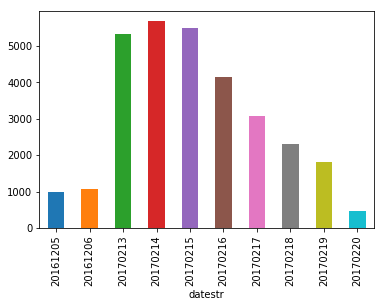

In [8]:
x6_tr, x6_ts = train_test_filenames(data,'C. pipiens', test_dates=['20161206', '20161205']) 

In [9]:
x1_tr, x1_ts = x1_tr.sample(12800), x1_ts.sample(2000)
x2_tr, x2_ts = x2_tr.sample(12800), x2_ts.sample(2000)
x3_tr, x3_ts = x3_tr.sample(12800), x3_ts.sample(2000)
x4_tr, x4_ts = x4_tr.sample(12800), x4_ts.sample(2000)
x5_tr, x5_ts = x5_tr.sample(12800), x5_ts.sample(2000)
x6_tr, x6_ts = x6_tr.sample(12800), x6_ts.sample(2000)

## Creating TRAIN/VAL/TEST sets

In [10]:
X_train = pd.concat([x1_tr, x2_tr, x3_tr, x4_tr, x5_tr, x6_tr], axis=0)
X_test = pd.concat([x1_ts, x2_ts, x3_ts, x4_ts, x5_ts, x6_ts], axis=0)

In [11]:
y_train = X_train.apply(lambda x: x.split('/')[len(BASE_DIR.split('/'))])
y_test = X_test.apply(lambda x: x.split('/')[len(BASE_DIR.split('/'))])

In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [13]:
X_test = X_test.tolist()

In [14]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
X_train,y_train = shuffle(X_train.tolist(),y_train.tolist(), random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [15]:
keys = pd.Series(le.inverse_transform(y_train)).value_counts().index.tolist()
values = pd.Series(y_train).value_counts().index.tolist()
mapping = dict(zip(keys, values))
sorted(mapping.items(), key=lambda x: x[1])

[('Ae. aegypti', 0),
 ('Ae. albopictus', 1),
 ('An. arabiensis', 2),
 ('An. gambiae', 3),
 ('C. pipiens', 4),
 ('C. quinquefasciatus', 5)]

# Modelling

In [16]:
from utils_train import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.utils import to_categorical
from wavhandler import *
import math
from utils_train import TrainConfiguration

In [17]:
traincf = TrainConfiguration(X=X_train, y=y_train)

In [18]:
#model_name='mosquitoes_validation_2' 
#setting='raw'
#top_weights_path = TEMP_DATADIR + str(model_name) + '.h5'
targets = 6
#batch_size = 32

# Build the Neural Network
model = Sequential()

model.add(Conv1D(16, 3, activation='relu', input_shape=(5000, 1)))
model.add(Conv1D(16, 3, activation='relu'))
model.add(BatchNormalization())

model.add(Conv1D(32, 3, activation='relu'))
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling1D(2))
model.add(Conv1D(64, 3, activation='relu'))
model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling1D(2))
model.add(Conv1D(128, 3, activation='relu'))
model.add(Conv1D(128, 3, activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling1D(2))
model.add(Conv1D(256, 3, activation='relu'))
model.add(Conv1D(256, 3, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling1D())

model.add(Dropout(0.5))
model.add(Dense(targets, activation='softmax'))

model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

callbacks_list = traincf.callbacks_list

In [ ]:
model.fit_generator(train_generator(X_train, y_train, batch_size=traincf.batch_size,
                                   target_names=traincf.target_names,
                                   setting=traincf.setting),
                   steps_per_epoch = int(math.ceil(float(len(X_train)) / float(traincf.batch_size))),
                   epochs=traincf.epochs,
                   validation_data = valid_generator(X_val, y_val,
                                                    batch_size=traincf.batch_size,
                                                    target_names=traincf.target_names,
                                                    setting=traincf.setting),
                    validation_steps=int(math.ceil(float(len(X_test))/float(traincf.batch_size))),
                    callbacks = traincf.callbacks_list)

Epoch 1/100
 241/1920 [==>...........................] - ETA: 7:28 - loss: 1.0957 - accuracy: 0.5835

In [ ]:
model.load_weights(traincf.top_weights_path)
y_pred = model.predict_generator(valid_generator(X_test, 
                                                    y_test, 
                                                    batch_size=traincf.batch_size, 
                                                    setting=traincf.setting, 
                                                    target_names=traincf.target_names),
        steps = int(math.ceil(float(len(X_test)) / float(traincf.batch_size))))

In [ ]:
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
x = confusion_matrix(np.array(y_test), np.argmax(y_pred, axis=1))

plt.figure(figsize=(16,12))
sns.set(font_scale=1.2)
ticks = ['Ae. aegypti',' Ae. albopictus','An. arabiensis','An. gambiae','C. pipiens','C. quinquefasciatus']
ticks_short = ['Ae. aeg','Ae. alb','An. arab','An. gambiae','C. pip','C. quin']
sns.heatmap(x, annot=True, fmt='.0f', xticklabels=ticks, yticklabels=ticks_short)

In [ ]:
model.load_weights(traincf.top_weights_path)
loss, acc = model.evaluate_generator(valid_generator(X_test, 
                                                    y_test, 
                                                    batch_size=traincf.batch_size, 
                                                    setting=traincf.setting, 
                                                    target_names=traincf.target_names),
        steps = int(math.ceil(float(len(X_test)) / float(traincf.batch_size))))

print('loss', loss)
print('Test accuracy:', acc)